In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Path to your dataset
train_dir = "c:/users/butech/Downloads/image_dataset_3labeled/train"
val_dir = "c:/users/butech/Downloads/image_dataset_3labeled/validation"

# Load datasets
train_dataset_raw = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

val_dataset_raw = image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

# Get class names
class_names = train_dataset_raw.class_names

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

# Normalize and apply data augmentation
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image, training=True)
    return image, label

train_dataset = train_dataset_raw.map(preprocess)
val_dataset = val_dataset_raw.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))

# Prefetch datasets for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Initially freeze the base model

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = 'c:/users/butech/Downloads/checkpoint_saved_efficientnet_balanced_data.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Check if a checkpoint exists
try:
    model = tf.keras.models.load_model(checkpoint_path)
    print("Checkpoint loaded successfully. Resuming training...")
except Exception as e:
    print("No checkpoint found. Starting training from scratch.")

# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:100]:  # Adjust the number of frozen layers based on dataset size
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the fine-tuned model for 70 epochs
history = model.fit(
    train_dataset,
    epochs=70,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, lr_schedule]
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on validation dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Found 14876 files belonging to 3 classes.
Found 3620 files belonging to 3 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Checkpoint loaded successfully. Resuming training...
Epoch 1/70
105/465 ━━━━━━━━━━━━━━━━━━━━ 7:57 1s/step - accuracy: 0.5873 - loss: 0.8309

110/465 ━━━━━━━━━━━━━━━━━━━━ 7:54 1s/step - accuracy: 0.5875 - loss: 0.8309

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Path to your dataset
train_dir = "c:/users/butech/Downloads/image_dataset_3labeled/train"
val_dir = "c:/users/butech/Downloads/image_dataset_3labeled/validation"

# Load datasets
train_dataset_raw = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

val_dataset_raw = image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

# Get class names
class_names = train_dataset_raw.class_names

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

# Normalize and apply data augmentation
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image, training=True)
    return image, label

train_dataset = train_dataset_raw.map(preprocess)
val_dataset = val_dataset_raw.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))

# Prefetch datasets for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load EfficientNetB3 model with pre-trained weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Initially freeze the base model

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = 'c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:100]:  # Adjust the number of frozen layers based on dataset size
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the fine-tuned model for 70 epochs
history = model.fit(
    train_dataset,
    epochs=70,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, lr_schedule]
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on validation dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Found 14876 files belonging to 3 classes.
Found 3620 files belonging to 3 classes.
Epoch 1/70
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3574 - loss: 1.1236
Epoch 1: val_accuracy improved from -inf to 0.42072, saving model to c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 1598s 3s/step - accuracy: 0.3574 - loss: 1.1235 - val_accuracy: 0.4207 - val_loss: 1.0654 - learning_rate: 1.0000e-05
Epoch 2/70
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4296 - loss: 1.0604
Epoch 2: val_accuracy improved from 0.42072 to 0.52983, saving model to c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 1525s 3s/step - accuracy: 0.4296 - loss: 1.0603 - val_accuracy: 0.5298 - val_loss: 0.9486 - learning_rate: 1.0000e-05
Epoch 3/70
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4809 - loss: 1.0073
Epoch 3: val_accuracy improved from 0.52983 to 0.57901, saving model to c:/users/butech/Downloads/c

Found 3620 files belonging to 3 classes.
114/114 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.3169 - loss: 1.6718
Validation Loss: 1.6076602935791016
Validation Accuracy: 0.3190607726573944
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━

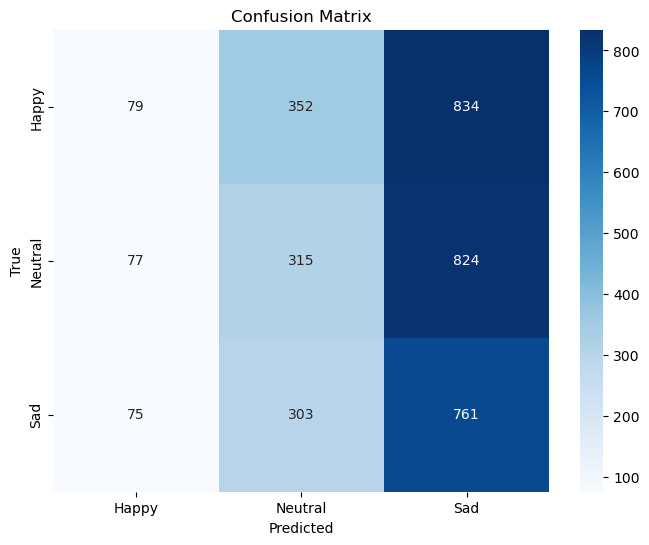

Classification Report:
              precision    recall  f1-score   support

       Happy       0.34      0.06      0.11      1265
     Neutral       0.32      0.26      0.29      1216
         Sad       0.31      0.67      0.43      1139

    accuracy                           0.32      3620
   macro avg       0.33      0.33      0.27      3620
weighted avg       0.33      0.32      0.27      3620



In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
best_model = tf.keras.models.load_model(checkpoint_path)

# Load validation dataset from directory (assuming validation folder contains happy, neutral, sad subfolders)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "c:/users/butech/Downloads/image_dataset_3labeled/validation",  # Path to your validation folder
    image_size=(224, 224),  # Resize images to match model input size (adjust if needed)
    batch_size=32,  # Adjust batch size as needed
    label_mode='int'  # Use integer labels (based on folder names)
)

# Evaluate the best model on the validation dataset
val_loss, val_accuracy = best_model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate predictions for the validation dataset
y_true = []
y_pred = []

# Iterate over the validation dataset to collect predictions
for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())  # Convert labels to numpy
    y_pred.extend(np.argmax(preds, axis=1))  # Get predicted class (from probabilities)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Replace `class_names` with your actual class names
class_names = ["Happy", "Neutral", "Sad"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


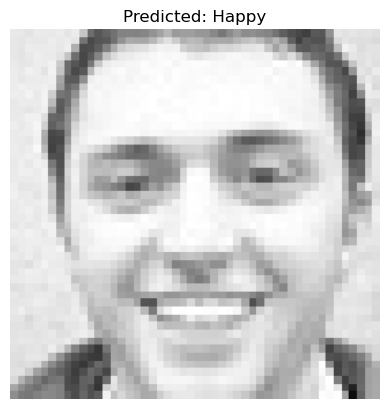

Predicted class: Happy


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/30.jpg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


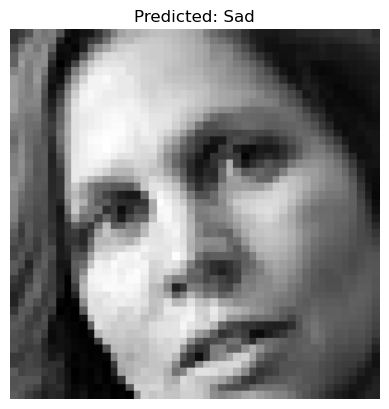

Predicted class: Sad


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/615.jpg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step


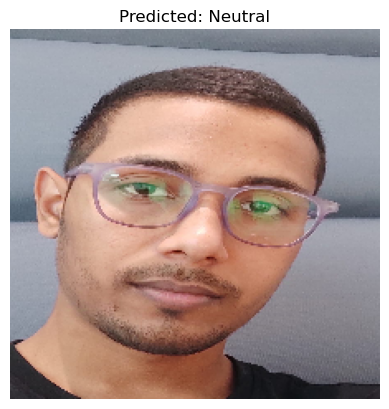

Predicted class: Neutral


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/majid.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step


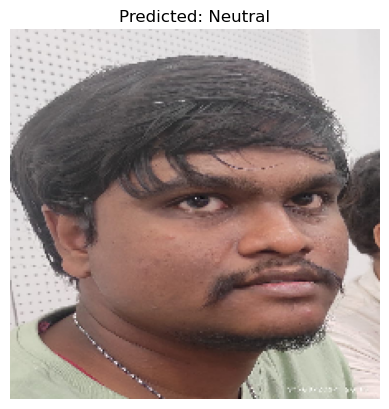

Predicted class: Neutral


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/poli.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step


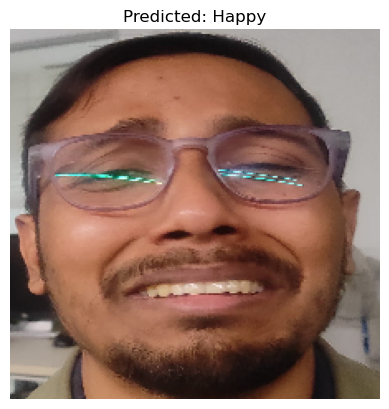

Predicted class: Happy


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/majid1.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step


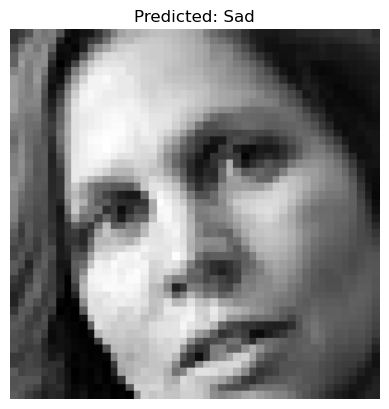

Predicted class: Sad


In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb4.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/615.jpg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step


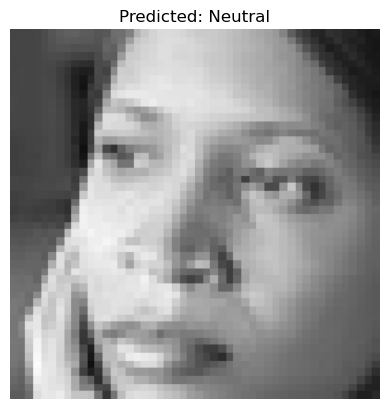

Predicted class: Neutral


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/44.jpg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step


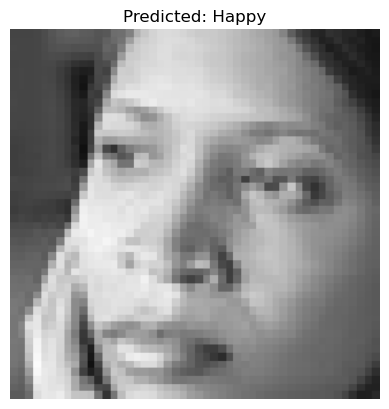

Predicted class: Happy


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb4.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/44.jpg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


Found 3620 files belonging to 3 classes.
114/114 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.3237 - loss: 1.4757
Validation Loss: 1.488811731338501
Validation Accuracy: 0.32348066568374634
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━

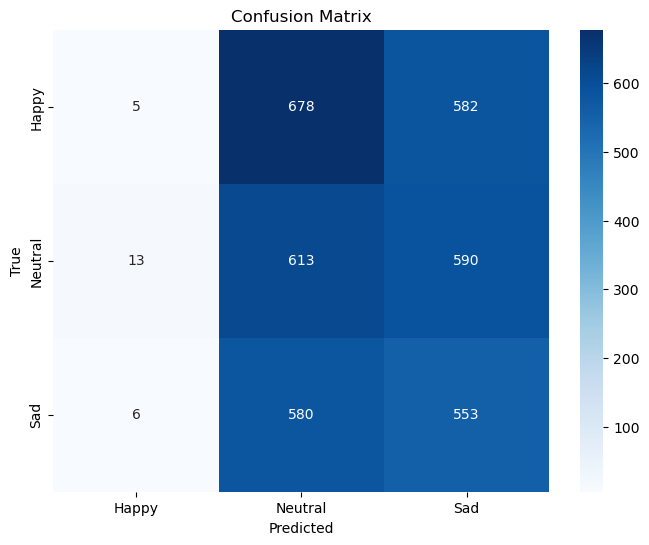

Classification Report:
              precision    recall  f1-score   support

       Happy       0.21      0.00      0.01      1265
     Neutral       0.33      0.50      0.40      1216
         Sad       0.32      0.49      0.39      1139

    accuracy                           0.32      3620
   macro avg       0.29      0.33      0.26      3620
weighted avg       0.28      0.32      0.26      3620



In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb4.keras"
best_model = tf.keras.models.load_model(checkpoint_path)

# Load validation dataset from directory (assuming validation folder contains happy, neutral, sad subfolders)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "c:/users/butech/Downloads/image_dataset_3labeled/validation",  # Path to your validation folder
    image_size=(224, 224),  # Resize images to match model input size (adjust if needed)
    batch_size=32,  # Adjust batch size as needed
    label_mode='int'  # Use integer labels (based on folder names)
)

# Evaluate the best model on the validation dataset
val_loss, val_accuracy = best_model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate predictions for the validation dataset
y_true = []
y_pred = []

# Iterate over the validation dataset to collect predictions
for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())  # Convert labels to numpy
    y_pred.extend(np.argmax(preds, axis=1))  # Get predicted class (from probabilities)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Replace `class_names` with your actual class names
class_names = ["Happy", "Neutral", "Sad"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step


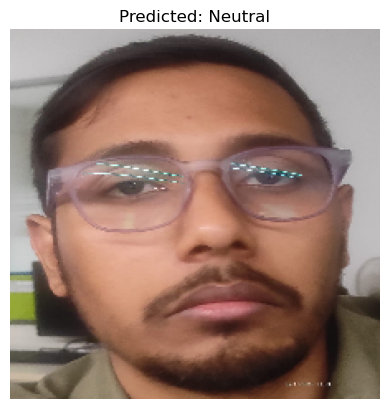

Predicted class: Neutral


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/majid2.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step


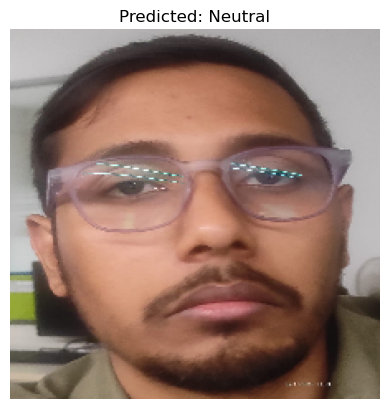

Predicted class: Neutral


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb4.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/majid2.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step


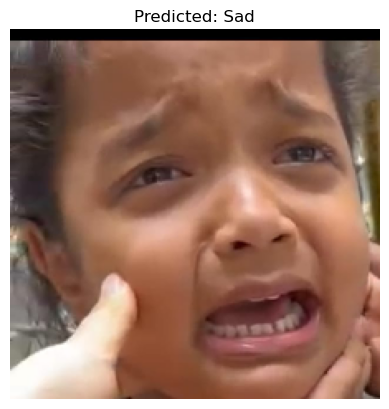

Predicted class: Sad


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb4.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/maera.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


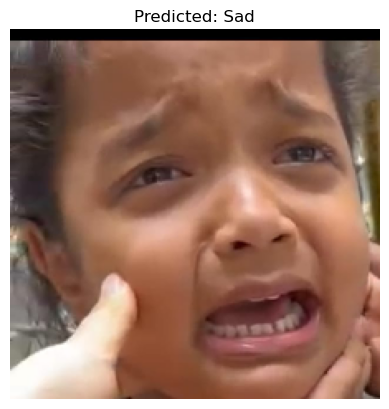

Predicted class: Sad


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnet_balanced_data.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/maera.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step


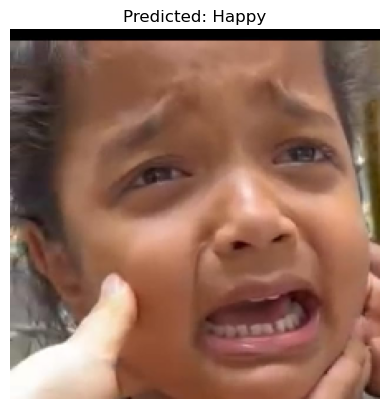

Predicted class: Happy


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the best model saved during training
checkpoint_path = "c:/users/butech/Downloads/checkpoint_saved_efficientnetb3.keras"
model = tf.keras.models.load_model(checkpoint_path)

# Path to the image you want to test
img_path = "c:/users/butech/Downloads/maera.jpeg"

# Load the image and resize it to match the input size of the model (224x224 for EfficientNetB3)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra batch dimension since the model expects a batch of images
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (if the model was trained on normalized images)
img_array = img_array / 255.0  # Assuming the model was trained with normalization

# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class (assuming the model has 3 classes)
predicted_class = np.argmax(predictions, axis=1)

# Replace these class names with the actual ones for your dataset
class_names = ["Happy", "Neutral", "Sad"]

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')  # Turn off axes
plt.show()

# Print the prediction
print(f"Predicted class: {class_names[predicted_class[0]]}")
